## RNN-based Sound Source Separation

Re-implementation of the paper "Joint Optimization of Masks and Deep Recurrent Neural Networks for Monaural Source Separation".
The network has a deep LSTM structure (L lstm blocks). The input to the network is the spectrogram of the mixture. The output will be separated sources. 

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import csv
import time

In [2]:
#!pip install numpy --upgrade
#!pip install torchaudio
import torchaudio

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
class SS_RNN(nn.Module):
    def __init__(self, Ns=2, L=1, Nf=1024):
        """
        Ns : number of sources in the mixture
        L  : number of LSTM blocks
        Nf : input vectors dimension (number of frequency bins)
        """
        hid_size = 16
        super(SS_RNN, self).__init__()
        self.lstm = nn.LSTM(input_size=Nf, hidden_size=hid_size, num_layers=L, batch_first=True, dropout=0, bidirectional=False)
        self.fc1 = nn.Sequential(nn.Linear(hid_size, Nf), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(hid_size, Nf), nn.ReLU())
    
    def forward(self, x):
        z,(_,_) = self.lstm(x)
        y1 = self.fc1(z)
        y2 = self.fc2(z)
        y = y1 + y2
        y1 /= (y + 1e-6) # mask for source 1
        y2 /= (y + 1e-6) # mask for source 2
        out1 = y1 * x
        out2 = y2 * x
        return out1, out2

In [92]:
# spectrogram parameters
dft_size = 1024
hop_size = 512
zero_pad=dft_size//2

# network
Ns = 2               # number of sources in the mixture
L = 1                # number of stacked layers of LSTM
Nf = int(dft_size/2)+1 # input features dimension
#net = SS_RNN(Ns, L, Nf)
net = torch.load('net_L'+str(L)+'_Nf'+str(Nf))

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=2e-4)
gamma = 0.5

# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = net.to(device)

# reading training data paths
file_name = 'mix_2_spk_tr.txt'
S1 = []
S2 = []
s1_s2_ratio = []
with open(file_name, newline='') as csvfile:
    mix_files = csv.reader(csvfile, delimiter=' ')
    for row in mix_files:
        S1.append(row[0])
        S2.append(row[2])
        s1_s2_ratio.append(10**(float(row[1])/10))


# Spectrogarm
TorchSpec = torchaudio.transforms.Spectrogram(n_fft=dft_size, hop_length=hop_size, power=1) # function to obtain spectrogram
fs = 8000 # sample rate for audio files
resample = torchaudio.transforms.Resample(new_freq=fs)
length = 4 * fs # we fix the length of all inputs to 4 seconds

# Constructing the training data
T = 1 + (length // hop_size)
length = T * hop_size

N_tr = int(len(S1)) # number of training samples
s1_spec = torch.zeros(N_tr, T+1, Nf)
s2_spec = torch.zeros(N_tr, T+1, Nf)
X_spec  = torch.zeros(N_tr, T+1, Nf)

t_begin = time.time() # to calculate the simulation duration
"""
for j in range(N_tr):
    s1_path = S1[j]
    s2_path = S2[j]
    s1, sr = torchaudio.load(s1_path)
    s2, _ = torchaudio.load(s2_path)
    s1 = resample(s1)
    s2 = resample(s2)
        
    # fixing the length
    if s1.size()[1] > length:
        s1 = s1[:,:length]
    elif s1.size()[1] < length:
        pad = torch.zeros(1, length - s1.size()[1])
        s1 = torch.cat((s1, pad), dim=1)
    if s2.size()[1] > length:
        s2 = s2[:,:length]
    elif s2.size()[1] < length:
        pad = torch.zeros(1, length - s2.size()[1])
        s2 = torch.cat((s2, pad), dim=1)
        
    # normalization
    s1 /= torch.sqrt(torch.sum(s1**2))
    s2 /= torch.sqrt(torch.sum(s2**2))
        
    # making mixture
    x = s1 * s1_s2_ratio[j] + s2

    # spectrogram magnitude
    X_spec[j,:,:]  = torch.transpose(TorchSpec(x),1,2)
    s1_spec[j,:,:] = torch.transpose(TorchSpec(s1),1,2)
    s2_spec[j,:,:] = torch.transpose(TorchSpec(s2),1,2)

torch.save(s1_spec, 's1_spec_Nf'+str(Nf))
torch.save(s2_spec, 's2_spec_Nf'+str(Nf))
torch.save(X_spec, 'X_spec_Nf'+str(Nf))
"""
X_spec  = torch.load('X_spec_Nf'+str(Nf))
s1_spec = torch.load('s1_spec_Nf'+str(Nf))
s2_spec = torch.load('s2_spec_Nf'+str(Nf))

N_tr = int(len(S1)/4) 
print("number of training samples: " + str(N_tr))
idx = np.arange(N_tr)

t_end = time.time()
duration = t_end - t_begin

print("Training set constructed in %d seconds. Training begins." % duration)

# Training
N_epoch = 201
Loss = np.zeros(N_epoch,)

t_0 = time.time()
for i in range(N_epoch):
    t_begin = time.time()

    # random shuffling of the input
    np.random.shuffle(idx)

    for j in range(N_tr):
        s1 = torch.unsqueeze(s1_spec[idx[j],:,:], 0).to(device)
        s2 = torch.unsqueeze(s2_spec[idx[j],:,:], 0).to(device)
        x = torch.unsqueeze(X_spec[idx[j],:,:], 0).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        out1, out2 = net(x)
        
        # PIT criterion (Permutation Invariant Training)
        loss1 = torch.sum((out1 - s1)**2) + torch.sum((out2 - s2)**2) - gamma * (torch.sum((out1 - s2)**2) + torch.sum((out2 - s1)**2))
        loss2 = torch.sum((out2 - s1)**2) + torch.sum((out1 - s2)**2) - gamma * (torch.sum((out2 - s2)**2) + torch.sum((out1 - s1)**2))
        loss = torch.min(loss1, loss2)
        loss.backward()
        
        Loss[i] += loss.item()
        
        # optimization step
        optimizer.step()

    t_end = time.time()
    print("epoch %d done in %d seconds, loss: %.3f" %(i, t_end-t_begin, Loss[i]/N_tr))
    torch.save(net, 'net_L'+str(L)+'_Nf'+str(Nf))
    
Loss /= N_tr
t_end = time.time()
duration = t_end - t_0
print('Training took %d seconds' % duration)

cuda:0


KeyboardInterrupt: 

In [15]:
np.save('Loss_L2.npy', Loss)

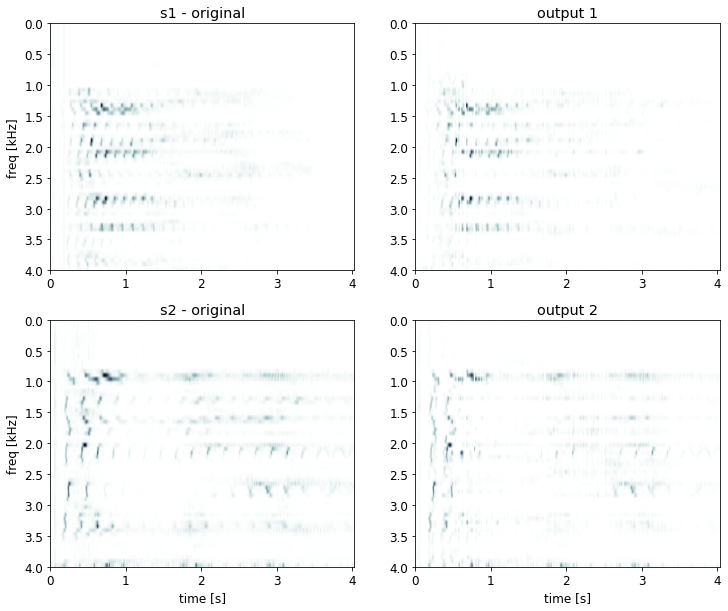

In [95]:
#net = torch.load('net_L1_Nf513')

plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
fig.subplots_adjust(hspace=0.2)
axes = axes.flatten()

example = 0
x = torch.unsqueeze(X_spec[example,:,:], 0).to(device)
out1, out2 = net(x)

axes[0].imshow(s1_spec.numpy()[example,:,:], extent = [0 , length/fs, fs/2000, 0], aspect='auto', cmap='bone_r')
axes[0].set_title('s1 - original')
#axes[0].set_xlabel('time [s]')
axes[0].set_ylabel('freq [kHz]')

axes[1].imshow(out1.detach().cpu().numpy()[0,:,:], extent = [0 , length/fs, fs/2000, 0], aspect='auto', cmap='bone_r')
axes[1].set_title('output 1')
#axes[1].set_xlabel('time [s]')
#axes[1].set_ylabel('freq [kHz]')

axes[2].imshow(s2_spec.numpy()[example,:,:], extent = [0 , length/fs, fs/2000, 0], aspect='auto', cmap='bone_r')
axes[2].set_title('s2 - original')
axes[2].set_xlabel('time [s]')
axes[2].set_ylabel('freq [kHz]')

axes[3].imshow(out2.detach().cpu().numpy()[0,:,:], extent = [0 , length/fs, fs/2000, 0], aspect='auto', cmap='bone_r')
axes[3].set_title('output 2')
axes[3].set_xlabel('time [s]')
#axes[3].set_ylabel('freq [kHz]')

plt.savefig('spectrograms')

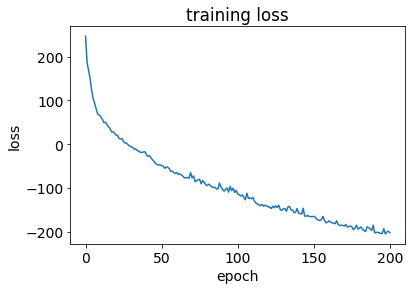

In [58]:
import matplotlib.pyplot as plt
plt.plot(Loss)
plt.title('training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('training loss')

In [49]:
#!pip install librosa
import librosa
import IPython.display as ipd
#sp, fs = librosa.load(s1_path, sr=fs)
#s1 = s1.numpy().reshape(-1,)
#plt.plot(s1)
#ipd.display(ipd.Audio(data=s1, rate=fs))

In [96]:
# Test
#del X_spec, s1_spec, s2_spec
#net = torch.load('net')
net = net.to(device)
net.eval()

TorchSpec = torchaudio.transforms.Spectrogram(n_fft=dft_size, hop_length=hop_size, power=1)

# reading test data paths
file_name = 'mix_2_spk_tt.txt'
S1 = []
S2 = []
s1_s2_ratio = []
with open(file_name, newline='') as csvfile:
    mix_files = csv.reader(csvfile, delimiter=' ')
    for row in mix_files:
        S1.append(row[0])
        S2.append(row[2])
        s1_s2_ratio.append(10**(float(row[1])/10))

N_tt = len(S1)
X_spec_tt = torch.zeros(N_tt, T+1, Nf)

s1_time_tt = torch.zeros(N_tt, 1, length)
s2_time_tt = torch.zeros(N_tt, 1, length)
x_time_tt = torch.zeros(N_tt, 1, length)

for j in range(N_tt):
    s1_path = S1[j]
    s2_path = S2[j]
    s1, sr = torchaudio.load(s1_path)
    s2, _ = torchaudio.load(s2_path)
    s1 = resample(s1)
    s2 = resample(s2)
        
    # fixing the length to 4 seconds
    if s1.size()[1] > length:
        s1 = s1[:,:length]
    elif s1.size()[1] < length:
        pad = torch.zeros(1, length - s1.size()[1])
        s1 = torch.cat((s1, pad), dim=1)
    if s2.size()[1] > length:
        s2 = s2[:,:length]
    elif s2.size()[1] < length:
        pad = torch.zeros(1, length - s2.size()[1])
        s2 = torch.cat((s2, pad), dim=1)
        
    # normalization
    s1 /= torch.sqrt(torch.sum(s1**2))
    s2 /= torch.sqrt(torch.sum(s2**2))
        
    # making mixture
    x = s1 * s1_s2_ratio[j] + s2

    s1_time_tt[j,0,:] = s1
    s2_time_tt[j,0,:] = s2
    x_time_tt[j,0,:] = x

    # spectrogram magnitude
    X_spec_tt[j,:,:]  = torch.transpose(TorchSpec(x),1,2)


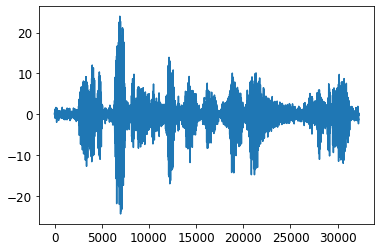

In [97]:
from scipy.signal import stft, istft
example = 0
x = x_time_tt[example,0,:].numpy().reshape(1,-1)
x_sp = torch.unsqueeze(X_spec_tt[example,:,:], 0).to(device)
out1, out2 = net(torch.abs(x_sp))

f, t, Zxx = stft(x, fs, nperseg=dft_size, noverlap = dft_size - hop_size)

s1_est_mag = out1.detach().cpu().numpy().transpose(0,2,1)

s1_est_ph = np.angle(Zxx)

S_s1_est = s1_est_mag * np.exp(1j*s1_est_ph)
_, s1_sep = istft(S_s1_est, fs, nperseg=dft_size, noverlap = dft_size - hop_size)

s1_sep = s1_sep.reshape(-1,)
plt.plot(s1_sep)
ipd.display(ipd.Audio(data=s1_sep, rate=fs))

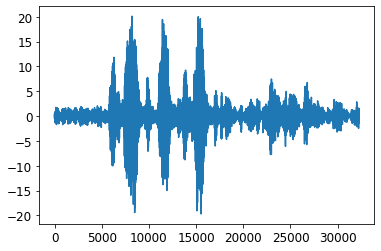

In [98]:
s2_est_mag = out2.detach().cpu().numpy().transpose(0,2,1)
s2_est_ph = np.angle(Zxx)
S_s2_est = s2_est_mag * np.exp(1j*s2_est_ph)
_, s2_sep = istft(S_s2_est, fs, nperseg=dft_size, noverlap = dft_size - hop_size)

s2_sep = s2_sep.reshape(-1,)
plt.plot(s2_sep)
ipd.display(ipd.Audio(data=s2_sep, rate=fs))

In [99]:
# saving the separated signals for statistics extraction
np.save('s1_sep.npy', s1_sep)
np.save('s2_sep.npy', s2_sep)
np.save('mixture.npy', x)

# original signals
np.save('s1_org.npy', s1_time_tt[example,0,:].numpy().reshape(1,-1))
np.save('s2_org.npy', s2_time_tt[example,0,:].numpy().reshape(1,-1))

In [111]:
# SDR

def sdr(y, z, SI=False):
    """
    y: original signal
    z: separated signal
    SI: scale invariant
    """
    if SI:
        a = (np.mean(y*z) / np.mean(y*y)) * y
        return 10*np.log10( np.mean((a**2)) / np.mean((a-z)**2))
    else:
        return 10*np.log10( np.mean((y*y)) / np.mean((y-z)**2))

In [123]:
SDR = 0
for k in range(N_tt):
    x = x_time_tt[k,0,:].numpy().reshape(1,-1)
    x_sp = torch.unsqueeze(X_spec_tt[k,:,:], 0).to(device)
    out1, out2 = net(torch.abs(x_sp))

    f, t, Zxx = stft(x, fs, nperseg=dft_size, noverlap = dft_size - hop_size)
    
    s1_est_mag = out1.detach().cpu().numpy().transpose(0,2,1)

    s1_est_ph = np.angle(Zxx)

    S_s1_est = s1_est_mag * np.exp(1j*s1_est_ph)
    _, s1_sep = istft(S_s1_est, fs, nperseg=dft_size, noverlap = dft_size - hop_size)

    s1_sep = s1_sep.reshape(-1,)
    s2_est_mag = out2.detach().cpu().numpy().transpose(0,2,1)
    s2_est_ph = np.angle(Zxx)
    S_s2_est = s2_est_mag * np.exp(1j*s2_est_ph)
    _, s2_sep = istft(S_s2_est, fs, nperseg=dft_size, noverlap = dft_size - hop_size)

    s2_sep = s2_sep.reshape(-1,)

    # Considering Permutations (PIT)
    sdr1 = max(sdr(s1_time_tt[k,0,:].numpy(), s1_sep, SI=True), sdr(s1_time_tt[k,0,:].numpy(), s2_sep, SI=True))
    sdr2 = max(sdr(s2_time_tt[k,0,:].numpy(), s2_sep, SI=True), sdr(s2_time_tt[k,0,:].numpy(), s1_sep, SI=True))
    SDR += sdr1 + sdr2
SDR /= (2*N_tt)
print('SDR: ', SDR)

SDR:  0.4049055545192793
